<a href="https://colab.research.google.com/github/Kulikov17/MLDS_CV/blob/main/cars_classification_effv2s1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Скачаем dataset из kaggle

In [1]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle competitions download -c hse-cars-competition

 99% 1.81G/1.82G [00:21<00:00, 87.1MB/s]
100% 1.82G/1.82G [00:21<00:00, 89.3MB/s]


In [ ]:
!unzip hse-cars-competition.zip

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

import numpy as np
import time
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image
from tqdm.auto import tqdm

matplotlib.style.use('ggplot')

In [5]:
train_ann = pd.read_csv('./annotation/train_ann.csv')

In [ ]:
len(train_ann)

8132

In [ ]:
train_ann.sample(3)

,imname,class
3869,train/31d2bc4d4be11ce72c1048442a9a1465.jpg,17
1809,train/2c16659b6cdda4e439b17e40709234dc.jpg,12
718,train/ada2ced8822a1035cce407466ff9bdef.jpg,158


In [6]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
device

device(type='cuda', index=0)

In [9]:
def get_train_transform(IMAGE_SIZE):
    train_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(25, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=8),
        transforms.ToTensor(),
        transforms.ColorJitter(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])
    return train_transform

# Validation transforms
def get_valid_transform(IMAGE_SIZE):
    valid_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])
    return valid_transform

In [10]:
class CarsDataset(Dataset):
    """Cars dataset."""

    def __init__(self, root_dir, imlist, transform=None):
        """
        Arguments:
            imlist(pandas DataFrame): DataFrame with columns file_name, class
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.imlist = imlist
        self.transform = transform

    def __len__(self):
        return len(self.imlist)

    def __getitem__(self, idx):
        impath, target = self.imlist.loc[idx]
        full_imname = os.path.join(self.root_dir, impath)

        if not os.path.exists(full_imname):
            print('No file ', full_imname)
            pass

        img = Image.open(full_imname).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, target

In [26]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2

Проверил на val, для каггла использую весь датасет

In [27]:
train_set = CarsDataset('./images',
                        train_ann,
                        transform=get_train_transform(IMAGE_SIZE))

val_set = CarsDataset('./images',
                      train_ann,
                      transform=get_valid_transform(IMAGE_SIZE))

In [28]:
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=BATCH_SIZE,
                                           num_workers=NUM_WORKERS,
                                           shuffle=True,
                                           pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_set,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS,
                                         pin_memory=True)

In [29]:
def save_model(epoch, model, optimizer, criterion, acc):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f"model_epoch_{epoch}_acc{acc:.4f}.pth")

In [30]:
def training_plots(train_acc, valid_acc, train_loss, valid_loss):
    # Accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()


In [31]:
def train(model, loader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(loader), total=len(loader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation.
        loss.backward()
        # Update the weights.
        optimizer.step()

    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(loader.dataset))
    return epoch_loss, epoch_acc

In [32]:
def validate(model, loader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(loader), total=len(loader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(loader.dataset))
    return epoch_loss, epoch_acc

In [33]:
def build_model(pretrained=True, fine_tune=True, num_classes=196):
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    else:
        print('[INFO]: Not loading pre-trained weights')

    model = models.efficientnet_v2_s(pretrained=pretrained)

    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False

    # Change the final classification head.
    model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)

    return model

In [34]:
def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss


def linear_combination(x, y, epsilon):
    return epsilon * x + (1 - epsilon) * y


class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon: float = 0.1, reduction='mean'):
        super().__init__()
        self.epsilon = epsilon
        self.reduction = reduction

    def forward(self, preds, target):
        n = preds.size()[-1]
        log_preds = F.log_softmax(preds, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return linear_combination(loss / n, nll, self.epsilon)

In [35]:
# Learning_parameters
lr = 1e-3
epochs = 30

In [36]:
# Load the model
model = build_model().to(device)

# Total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters")

total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters")

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr)

# Loss function
criterion = LabelSmoothingCrossEntropy()

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 mode='max',
                                                 patience=3,
                                                 threshold=0.9,
                                                 min_lr=1e-6,
                                                 verbose=True)

[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning all layers...
20,428,564 total parameters
20,428,564 training parameters


[INFO]: Epoch 1 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 4.498, training acc: 8.743
Validation loss: 3.511, validation acc: 23.328
--------------------------------------------------
[INFO]: Epoch 2 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 3.084, training acc: 34.051
Validation loss: 2.285, validation acc: 56.862
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 2.267, training acc: 59.272
Validation loss: 1.702, validation acc: 77.755
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.837, training acc: 72.479
Validation loss: 1.527, validation acc: 83.608
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.605, training acc: 80.583
Validation loss: 1.347, validation acc: 88.883
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.460, training acc: 85.268
Validation loss: 1.227, validation acc: 93.273
--------------------------------------------------
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
[INFO]: Epoch 7 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.213, training acc: 94.319
Validation loss: 1.074, validation acc: 97.922
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.137, training acc: 96.409
Validation loss: 1.042, validation acc: 98.426
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.111, training acc: 97.049
Validation loss: 1.021, validation acc: 98.660
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.081, training acc: 97.651
Validation loss: 1.005, validation acc: 98.795
--------------------------------------------------
Epoch 00010: reducing learning rate of group 0 to 1.0000e-05.
[INFO]: Epoch 11 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.064, training acc: 98.180
Validation loss: 1.001, validation acc: 98.942
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.062, training acc: 98.045
Validation loss: 0.998, validation acc: 99.041
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.057, training acc: 98.414
Validation loss: 0.998, validation acc: 99.139
--------------------------------------------------
[INFO]: Epoch 14 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.051, training acc: 98.377
Validation loss: 0.994, validation acc: 99.176
--------------------------------------------------
Epoch 00014: reducing learning rate of group 0 to 1.0000e-06.
[INFO]: Epoch 15 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.051, training acc: 98.352
Validation loss: 0.997, validation acc: 99.176
--------------------------------------------------
[INFO]: Epoch 16 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.053, training acc: 98.180
Validation loss: 0.993, validation acc: 99.188
--------------------------------------------------
[INFO]: Epoch 17 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.050, training acc: 98.586
Validation loss: 0.995, validation acc: 99.115
--------------------------------------------------
[INFO]: Epoch 18 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.048, training acc: 98.537
Validation loss: 0.995, validation acc: 99.102
--------------------------------------------------
[INFO]: Epoch 19 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.052, training acc: 98.438
Validation loss: 0.993, validation acc: 99.188
--------------------------------------------------
[INFO]: Epoch 20 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.050, training acc: 98.389
Validation loss: 0.993, validation acc: 99.127
--------------------------------------------------
[INFO]: Epoch 21 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.053, training acc: 98.328
Validation loss: 0.993, validation acc: 99.201
--------------------------------------------------
[INFO]: Epoch 22 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.050, training acc: 98.426
Validation loss: 0.995, validation acc: 99.139
--------------------------------------------------
[INFO]: Epoch 23 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.049, training acc: 98.352
Validation loss: 0.994, validation acc: 99.201
--------------------------------------------------
[INFO]: Epoch 24 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.049, training acc: 98.475
Validation loss: 0.993, validation acc: 99.201
--------------------------------------------------
[INFO]: Epoch 25 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.048, training acc: 98.487
Validation loss: 0.992, validation acc: 99.188
--------------------------------------------------
[INFO]: Epoch 26 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.047, training acc: 98.574
Validation loss: 0.991, validation acc: 99.164
--------------------------------------------------
[INFO]: Epoch 27 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.047, training acc: 98.623
Validation loss: 0.990, validation acc: 99.188
--------------------------------------------------
[INFO]: Epoch 28 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.046, training acc: 98.524
Validation loss: 0.994, validation acc: 99.127
--------------------------------------------------
[INFO]: Epoch 29 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.047, training acc: 98.512
Validation loss: 0.992, validation acc: 99.152
--------------------------------------------------
[INFO]: Epoch 30 of 30
Training


  0%|          | 0/255 [00:00<?, ?it/s]

Validation


  0%|          | 0/255 [00:00<?, ?it/s]

Training loss: 1.049, training acc: 98.561
Validation loss: 0.989, validation acc: 99.164
--------------------------------------------------
TRAINING COMPLETE


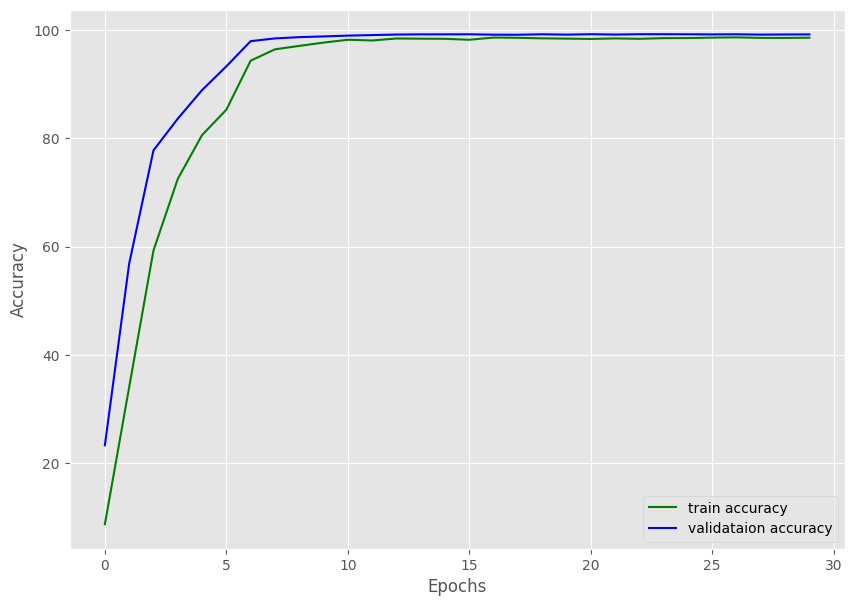

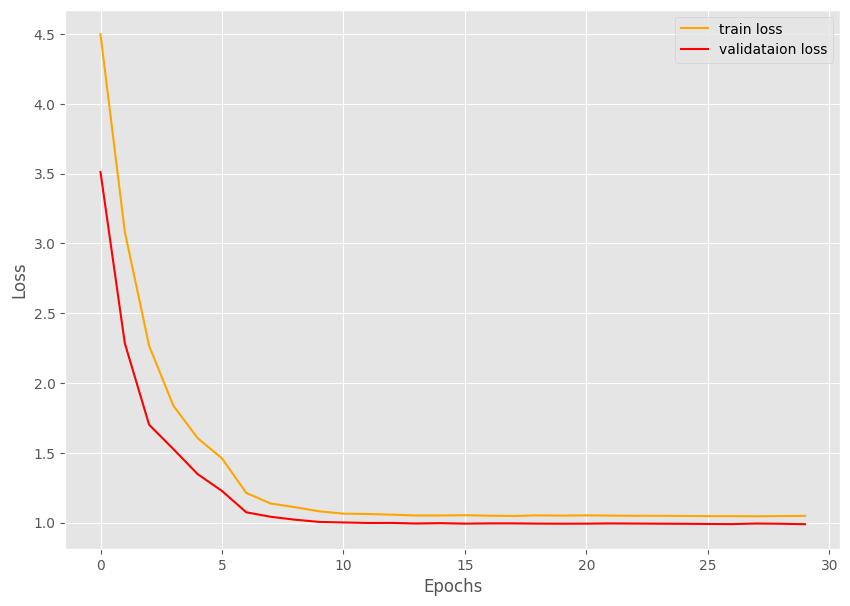

In [37]:
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, val_loader, criterion)

    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

    if scheduler is not None:
        scheduler.step(valid_epoch_acc)

    save_model(epoch, model, optimizer, criterion, valid_epoch_acc)


# Save the loss and accuracy plots.
training_plots(train_acc, valid_acc, train_loss, valid_loss)

print('TRAINING COMPLETE')

In [52]:
model_pth = './model_epoch_10_acc98.9424.pth'

#checkpoint = torch.load(model_pth, map_location=torch.device('cpu'))
checkpoint = torch.load(model_pth)

model = build_model().to(device)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning all layers...


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [53]:
test_dir = './images/test'
test_images = sorted(os.listdir('./images/test'))

predicts = []

for i in tqdm(range(len(test_images))):
    full_imname = os.path.join(test_dir, test_images[i])
    image = Image.open(full_imname)

    tranforms = get_valid_transform(IMAGE_SIZE)
    try:
      input_tensor = tranforms(image)
    except:
      image = image.convert('RGB')
      input_tensor = tranforms(image)

    input_batch = input_tensor.unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        output = model(input_batch)

    # Get predicted class
    _, predicted_class = torch.max(output, 1)
    predicts.append(predicted_class.item())

  0%|          | 0/8033 [00:00<?, ?it/s]

In [54]:
test_images = ['test/' + imname for imname in test_images]

In [55]:
csv_name = 'model_10_epoch_acc_98_9424.csv'
df = pd.DataFrame({'new_name': test_images, 'class': predicts})

with open(csv_name, 'w') as csv_file:
  df.to_csv(path_or_buf=csv_file,
            index=False,
            header=['new_name', 'class'],
            columns=['new_name', 'class'])